<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/kalman_commodity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 12.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
data = pd.read_csv('/content/Zinc Mini Futures Historical Data.csv')

In [3]:
data=data.set_index('Date')

In [4]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Vol.'], dtype='object')

In [5]:
data.tail()

,Open,High,Low,Close,Vol.
Date,,,,,
31-07-2025,266.85,266.85,264.15,265.50,2.46K
04-08-2025,262.95,265.40,261.80,265.15,2.32K
05-08-2025,265.60,267.45,264.80,265.00,2.13K
06-08-2025,265.35,268.40,264.80,268.00,2.85K
08-08-2025,268.75,270.40,267.85,269.85,2.18K


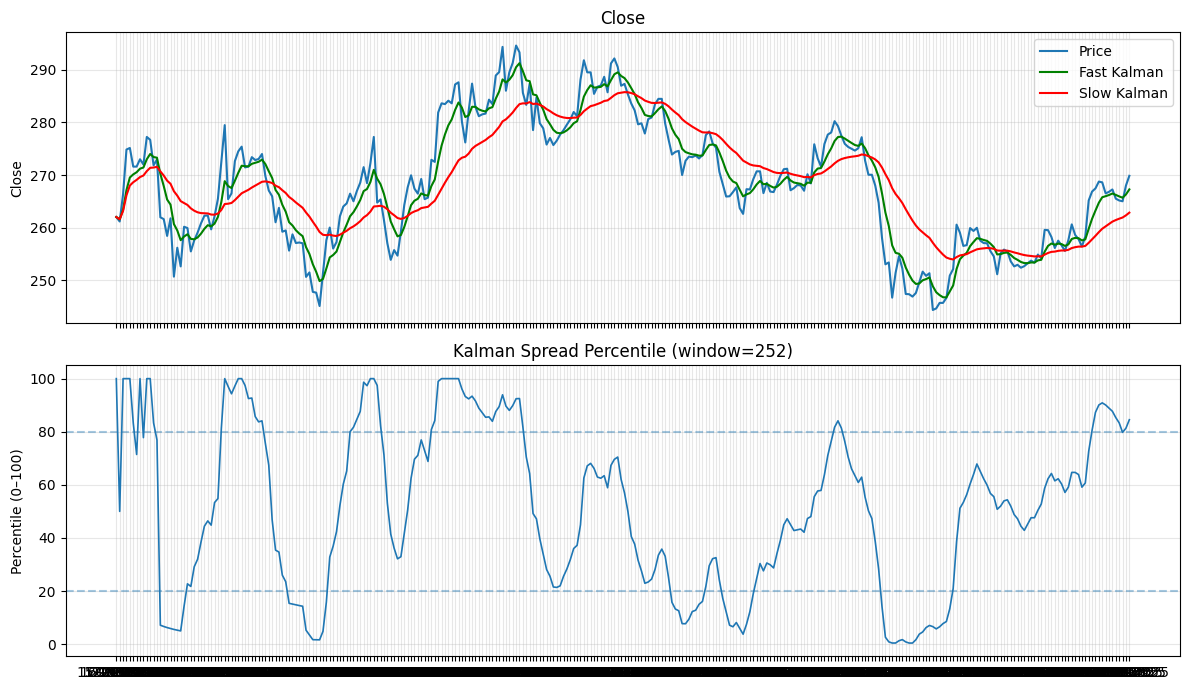

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _to_numeric_price(s: pd.Series) -> pd.Series:
    # handle "1,234.56" strings safely
    return pd.to_numeric(s.astype(str).str.replace(',', ''), errors='coerce')

def kalman_1d(series: pd.Series, delta: float, obs_var: float = 1e-3) -> pd.Series:
    """
    Returns the filtered series using a basic local-level Kalman filter
    (state: price level; transition matrix = 1).
    """
    kf = KalmanFilter(
        transition_matrices        = [1],
        observation_matrices       = [1],
        initial_state_mean         = series.iloc[0],
        initial_state_covariance   = 1.0,
        transition_covariance      = delta,      # process noise Q
        observation_covariance     = obs_var,    # observation noise R
    )
    state_means, _ = kf.filter(series.values)
    return pd.Series(state_means.flatten(), index=series.index)

# ---------------------------------------------------------------------------
# 3.  Compute fast & slow Kalman filters
#     Tune `delta_fast` and `delta_slow` until the speed feels right.
# ---------------------------------------------------------------------------
delta_fast = 1e-4   # higher  →  hugs price more closely
delta_slow = 5e-6


# ---------------------------------------------------------------------------
# 4.  Spread and percentile rank
# ---------------------------------------------------------------------------

def rolling_percentile(x: pd.Series, window: int = 252) -> pd.Series:
    """
    Percentile rank of the current value within the last `window` values (inclusive).
    Returns 0..100.
    """
    arr = x.values.astype(float)
    out = np.full_like(arr, np.nan, dtype=float)

    for i in range(len(arr)):
        j0 = max(0, i - window + 1)
        w = arr[j0:i+1]
        w = w[~np.isnan(w)]
        if w.size == 0:
            continue
        v = w[-1]
        out[i] = 100.0 * np.mean(w <= v)

    return pd.Series(out, index=x.index, name="kalman_spread_percentile")

# ---------- main ----------
# Ensure index is ascending and Price is numeric
df = data.tail(300).copy()


df['Close'] = _to_numeric_price(df['Close'])
close = df['Close'].dropna()

# Fast/slow Kalman filters (tune q_r_ratio as you like)
fast = kalman_1d(close, delta_fast, obs_var=1e-3)   # more responsive
slow = kalman_1d(close, delta_slow, obs_var=1e-3)  # smoother

# Spread and percentile score
spread = (fast - slow).rename("kalman_spread")
n = spread.notna().sum()
win = 252 if n >= 252 else max(30, int(n * 0.5))  # sensible default on small samples
spread_pct = rolling_percentile(spread, window=win)

# Align for plotting
plot_df = pd.concat([close.rename("Price"), spread_pct], axis=1)

# ---------- plot ----------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax1.plot(plot_df.index, plot_df['Price'], label='Price')
ax1.set_title('Close')
ax1.set_ylabel('Close')
ax1.plot(fast,color='green', label='Fast Kalman')
ax1.plot(slow,color='red', label='Slow Kalman')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(plot_df.index, plot_df['kalman_spread_percentile'], label='Kalman Spread Percentile (rolling)', linewidth=1.2)
ax2.axhline(80, linestyle='--', alpha=0.4)
ax2.axhline(20, linestyle='--', alpha=0.4)
ax2.set_title(f'Kalman Spread Percentile (window={win})')
ax2.set_ylabel('Percentile (0–100)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
